In [40]:
import numpy as np
import pandas as pd

data = pd.read_csv(r"data.csv.gz", compression='gzip')

# преобразование даты
data['period'] = pd.to_datetime(data['period'], format='%d/%m/%Y')

# преобразование времени
data['transac_time'] = data['trdatetime'].str[-11:-3]

# разные компоненты даты по столбцам
data['transac_day'] = data['trdatetime'].str[:2]
month_dict={'JAN':'01', 'FEB':'02', 'MAR':'03', 'APR':'04', 'MAY':'05', 'JUN':'06', 
            'JUL':'07', 'AUG':'08', 'SEP':'09', 'OCT':'10', 'NOV':'11', 'DEC':'12'}
data['transac_month'] = data['trdatetime'].str[2:5].map(month_dict)
data['transac_year'] = '20'+data['trdatetime'].str[5:7]

# комбинированное поле месяц-год
data['transac_year_month'] = '20'+data['trdatetime'].str[5:7]+'-'+data['trdatetime'].str[2:5].map(month_dict)

data.groupby('currency')['amount'].agg(['min', 'mean', 'median','max']).tail()
wiki_table = pd.read_csv(r"currency_codes_wiki.csv")
wiki_table = wiki_table.append({'num_code': 810, 'currency_code':'RUR','title':'Russian ruble'},ignore_index=True)
data = data.merge(wiki_table, left_on='currency', right_on='num_code', how='left')

data.merge(wiki_table, left_on='currency', right_on='num_code', how='left').head()
data = data.drop(['channel_type'], axis = 1)
data.groupby('title')['amount'].agg(['min', 'mean', 'median','max']).tail()
data.groupby('title')['amount'].agg(['min', 'mean', 'median','max']).tail().apply(lambda x:round(x,0))


,min,mean,median,max
title,,,,
Ugandan shilling,855000.0,855000.0,855000.0,855000.0
Ukrainian hryvnia,2.0,886.0,282.0,15451.0
United Arab Emirates dirham,2.0,491.0,96.0,24704.0
United States dollar,0.0,174.0,34.0,50000.0
Vietnamese đồng,10700.0,1806074.0,757500.0,35835000.0


In [45]:
mcc = pd.read_excel(r'mcc_codes.xls')
mcc = pd.read_excel(r'mcc_codes.xls',skiprows=1)
mcc = mcc.iloc[:,:-1]
mcc = mcc.rename(columns={'MCC CODE':'mcc','Program Type:':'category'})
data = data.merge(mcc, on='mcc', how='left')
data.head()

,mcc,period,trdatetime,amount,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title,category_x,category_y,category_x,category_y,category
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,0,810,POS,17:00:00,21,10,2017,2017-10,810,RUR,Russian ruble,Home Supply Warehouse,Home Supply Warehouse,Home Supply Warehouse,Home Supply Warehouse,Home Supply Warehouse
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,810,RUR,Russian ruble,Financial Institutions--Automated Cash Disburs...,Financial Institutions--Automated Cash Disburs...,Financial Institutions--Automated Cash Disburs...,Financial Institutions--Automated Cash Disburs...,Financial Institutions--Automated Cash Disburs...
2,5921,2017-12-01,05DEC17:00:00:00,767.0,0,810,POS,17:00:00,05,12,2017,2017-12,810,RUR,Russian ruble,"Package Stores--Beer, Wine, and Liquor","Package Stores--Beer, Wine, and Liquor","Package Stores--Beer, Wine, and Liquor","Package Stores--Beer, Wine, and Liquor","Package Stores--Beer, Wine, and Liquor"
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,0,810,POS,17:00:00,21,10,2017,2017-10,810,RUR,Russian ruble,Grocery Stores and Supermarkets,Grocery Stores and Supermarkets,Grocery Stores and Supermarkets,Grocery Stores and Supermarkets,Grocery Stores and Supermarkets
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,0,810,C2C_OUT,17:13:14,24,10,2017,2017-10,810,RUR,Russian ruble,Quasi Cash - Financial Institution - Merchandi...,Quasi Cash - Financial Institution - Merchandi...,Quasi Cash - Financial Institution - Merchandi...,Quasi Cash - Financial Institution - Merchandi...,Quasi Cash - Financial Institution - Merchandi...


In [46]:
#Отчет по средним тратам по категориям в разрезе месяцов (рубль)
report = pd.DataFrame()
currency = 810
rubbles = data[data['currency'] == currency]
dates = sorted(rubbles['transac_year_month'].unique())


for date in dates:
    buffer = rubbles[rubbles['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

    low = .05
    high = .95
    quant_df = buffer.quantile([low, high])

    filtered_df = buffer.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
    filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

    report = pd.concat([report, filtered_df]) # объединяем нашу таблицу

report = report.unstack().T # разворачиваем нашу таблицу 
report = round(report,2)
report.head()

transac_year_month                                       2016-10   2016-11  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   2294.42   
       Advertising Services                              1306.57   2674.30   
       AeroFlot                                         20423.09  12961.51   
       Agricultural Cooperatives                             NaN       NaN   

transac_year_month                                       2016-12   2017-01  \
       category                                                              
amount AIR STANA                                             NaN  14061.00   
       Accounting, Auditing, and Bookkeeping Services        NaN    960.00   
       Advertising Services                              1863.58   1367.67   
       AeroFlot                                         13992.32   8480.99   
       Agricultural Cooperatives                             NaN    702.00   

transac_year_month                                       2017-02   2017-03  \
       category                                                              
amount AIR STANA                                        10977.00       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                              1071.13   1117.51   
       AeroFlot                                          9766.56  11490.96   
       Agricultural Cooperatives                          624.00       NaN   

transac_year_month                                      2017-04  2017-05  \
       category                                                            
amount AIR STANA                                            NaN      NaN   
       Accounting, Auditing, and Bookkeeping Services       NaN   290.00   
       Advertising Services                             1783.02  1130.19   
       AeroFlot                                         9601.84  8756.14   
       Agricultural Cooperatives                        1879.50  1440.00   

transac_year_month                                       2017-06   2017-07  \
       category                                                              
amount AIR STANA                                        14092.00  11113.67   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                              1490.12   2049.76   
       AeroFlot                                         10632.52   9061.11   
       Agricultural Cooperatives                         1531.50       NaN   

transac_year_month                                       2017-08  2017-09  \
       category                                                             
amount AIR STANA                                        10691.00      NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   720.00   
       Advertising Services                              1517.03  1700.32   
       AeroFlot                                         10445.11  9230.78   
       Agricultural Cooperatives                             NaN   174.00   

transac_year_month                                      2017-10   2017-11  \
       category                                                             
amount AIR STANA                                            NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services       NaN       NaN   
       Advertising Services                             2955.57    533.81   
       AeroFlot                                         9766.24  16065.27   
       Agricultural Cooperatives                            NaN       NaN   

transac_year_month                                       2017-12   2018-01  \
       category                                                              
amount AIR STANA                           

In [47]:
#интерпретация в виде функции
def do_report(dataframe, currency_int):
    #Сначала мы создаем пустую таблицу в которую будем добавлять уже посчитанные значения.
    report = pd.DataFrame()
    currency = currency_int
    #Далее создаем срез из переданной таблицы и создаем отсортированный вектор дат
    df = dataframe[dataframe['currency'] == currency]
    dates = sorted(df['transac_year_month'].unique())

    #После этого начинается цикл, которй бегает по сформированному срезу и берет транзакции по определенной дате и выбирает значения ['transac_year_month','amount','category']
    for date in dates:
        buffer = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

        # посчитаем значения квартилей по которым будем обрезать наши значния в транзакциях (мы отбрасываем по 5% максимальных значений и 
        # столько же минимальных, тем самым очищая от выбросов, которые могут исказить наши средние значения)
        low = .05
        high = .95
        quant_df = buffer.quantile([low, high])

        # отфильтруем значения 
        filtered_df = buffer.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
        filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

        # объединяем нашу посчитанную таблицу с главной
        report = pd.concat([report, filtered_df])

    # разворачиваем нашу таблицу, транспонируем и удаляем одну колонку по которой индексировались
    report = report.unstack().T
    
    """
    Учли случай, когда у нас получается слишком маленький отчет и наше отсечение порогов захватывает все записи и у нас
    остается пустой отчет, который приводит к ошибке в следующей функции, которая записывает отчет в excel.
    """
    if report.shape[0] == 0: # сравниваем длину нашего отчета с нулем
        
        report = pd.DataFrame() # обнуляем наш отчет
        
        # для каждой из дат считаем все те же операции, что и выше, но без отсечения выбросов.
        for date in dates:
            buffer = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])
            buffer = buffer.groupby(['transac_year_month','category']).mean()
            report = pd.concat([report, buffer])
            return round(report,2) # возвращаем таблицу с округленными значениями
    else:
        return round(report,2)

In [49]:
rep = do_report(data,484)
rep

transac_year_month                                         2017-02  2017-05  \
       category                                                               
amount Artist Supply and Craft Stores                       600.00      NaN   
       Bus Lines, includes Charters/Tour Buses                 NaN      NaN   
       Business Services                                       NaN      NaN   
       Buying and Shopping Services and Clubs                  NaN    800.0   
       Caterers - Prepare & Delivery                           NaN      NaN   
       Civic, Social, and Fraternal Associations               NaN      NaN   
       Direct Marketing/Direct Marketers--Not Elsewher...      NaN    950.0   
       Drug Stores and Pharmacies                              NaN    437.6   
       Eating Places and Restaurants                        349.23    680.0   
       Freezer & Locker Meat Provisions                        NaN      NaN   
       Gift, Card, Novelty, and Souvenir Stores            1005.00      NaN   
       Lodging - Hotels, Motels, and Resorts                799.99    150.0   
       Miscellaneous Food Stores-Convenience Stores an...    86.00    417.0   
       Miscellaneous General Merchandise                       NaN      NaN   
       Package Stores--Beer, Wine, and Liquor               269.84      NaN   
       Quick Payment Service-Fast Food Restaurants             NaN      NaN   
       Shoe Stores                                             NaN    959.0   
       Taxicabs and Limousines                               93.72      NaN   
       Telecommunication Services, Including Local and...   369.00      NaN   
       Tourist Attractions and Exhibits                      70.00      NaN   
       Utilities-Electric, Gas, Water, and Sanitary            NaN      NaN   

transac_year_month                                         2017-06  
       category                                                     
amount Artist Supply and Craft Stores                          NaN  
       Bus Lines, includes Charters/Tour Buses              280.00  
       Business Services                                    370.00  
       Buying and Shopping Services and Clubs                  NaN  
       Caterers - Prepare & Delivery                         82.00  
       Civic, Social, and Fraternal Associations            317.50  
       Direct Marketing/Direct Marketers--Not Elsewher...      NaN  
       Drug Stores and Pharmacies                              NaN  
       Eating Places and Restaurants                        292.34  
       Freezer & Locker Meat Provisions                     543.31  
       Gift, Card, Novelty, and Souvenir Stores              81.00  
       Lodging - Hotels, Motels, and Resorts                   NaN  
       Miscellaneous Food Stores-Convenience Stores an...      NaN  
       Miscellaneous General Merchandise                    150.00  
       Package Stores--Beer, Wine, and Liquor                  NaN  
       Quick Payment Service-Fast Food Restaurants           60.00  
       Shoe Stores                                             NaN  
       Taxicabs and Limousines                                 NaN  
       Telecommunication Services, Including Local and...      NaN  
       Tourist Attractions and Exhibits                     116.67  
       Utilities-Electric, Gas, Water, and Sanitary         172.00

In [50]:
#посмотрим, какие транзакционные категории у нас есть
data.trx_category.unique()

array(['POS', 'DEPOSIT', 'C2C_OUT', 'WD_ATM_ROS', 'BACK_TRX',
       'WD_ATM_PARTNER', 'WD_ATM_OTHER', 'C2C_IN', 'CAT', 'CASH_ADV'],
      dtype=object)

In [56]:
def write_excel_cyclicaly(dataframe, dataframe_name):
    import openpyxl
    """
    Эта функция циклично добавляет табличку на новыый лист с названием этой таблицы, используя конструкцию with
    
    """

    with pd.ExcelWriter(r'results/report.xlsx', engine='openpyxl') as writer:
        writer.book = book
        writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

        dataframe.to_excel(writer, '{}'.format(str(dataframe_name)))
        writer.save()  

In [58]:
# определяем транзакционные категории конкретно для выбранного нами кода валюты
trx_cats = data[data['currency'] == 810]['trx_category'].unique()

# создаем/инициализируем файл 
import openpyxl
filepath = r"results"
book = openpyxl.Workbook()
book.save(filepath+'report.xlsx')

# цикл создания отчетов и записи в эксель файл
for trx_cat in trx_cats:
    report = do_report(data[data['trx_category'] == trx_cat], 810)
    write_excel_cyclicaly(report, '{}'.format(trx_cat))

In [61]:
#отчет по оттоку(сколько людей уходили в текущий месяц, сравнивая его с предыдущим)
"""
`del previous, current` - Строчка которая, удаляет вектора 
Если вылезла ошибка, то нужно просто закомментировать, а потом раскомментировать, чтобы первая ячейка была всегда np.nan, 
потому что мы считаем отношение к прошлом месяцу, данными к которым мы еще не обладаем.
""" 
# del previous, current 
churn_array = []
#создаем таблицу оттока

for month in sorted(data['transac_year_month'].unique()):
    # может появится ошибка, если у нас нет значения за прошлый период. Для того, чтобы это не помешало продолжить цикл, используем try ... except
    try:
        # находим вектор айдишников пользователей в текущем месяце
        current = data[data['transac_year_month'] == month]['cl_id'].unique()
        # находим пересечение с прошлым месяцем, точнее инфертированное пересечение или те значения, которых нет в текущем месяце, сравнивая с предыдущим
        churned_idx = np.isin(previous, current, invert=True) 
        # индексируемся, используя вектор True/False значений, получая только значения айдишников пользователей
        churned = previous[churned_idx] 
        # считаем длину вектора, количество "оттекших" пользователей
        churn_array.append(len(churned))
        # переназначаем текущий вектор айдишников на прошлый период, чтобы сравнивать уже со следующим периодом
        previous = current
    except NameError:
        churn_array.append(np.nan)
        previous = data[data['transac_year_month'] == month]['cl_id'].unique()
churn_table = pd.DataFrame({'months':sorted(data['transac_year_month'].unique()),
                            'churn':churn_array
                           }, columns=['months','churn'])
churn_table

,months,churn
0,2016-10,0
1,2016-11,21
2,2016-12,107
3,2017-01,313
4,2017-02,919
5,2017-03,1220
6,2017-04,1155
7,2017-05,595
8,2017-06,841
9,2017-07,946


In [62]:
churn_table.to_csv(r'results/churn.csv',index=False)

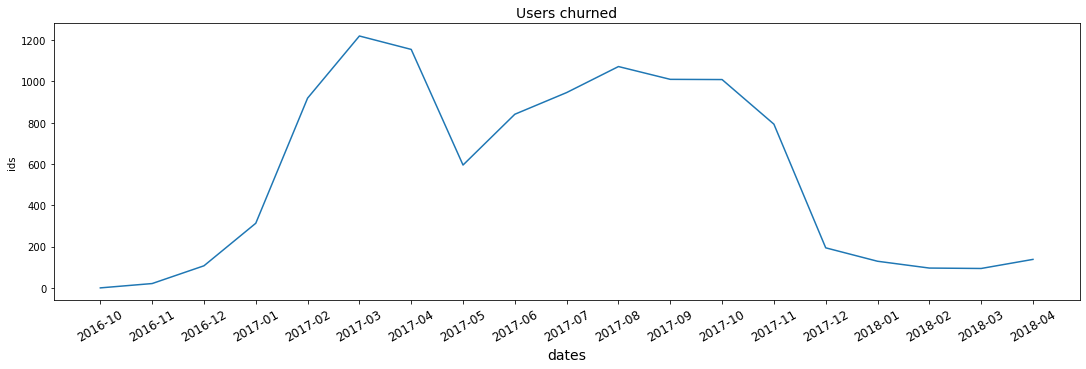

In [64]:
#график оттока пользователей по месяцам
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15,5))
churn_table['churn'].plot()

plt.xlabel('dates', fontsize=14)
ax = plt.gca()
plt.xticks(np.arange(0, len(dates), 1.0))
ax.set_xticklabels(churn_table['months'], fontsize=12, rotation=30)
plt.tight_layout()

plt.ylabel('ids')
plt.xlabel('dates')
plt.title('Users churned', fontsize=14)
plt.savefig(r'results/churn.png', dpi=300, bbox_inches='tight')
plt.show()